<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/gans_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating GANs From Scratch

* [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* Video: [GANs from Scratch](https://www.youtube.com/watch?v=T-MCludVNn4)

In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Implementing DCGANs in Keras

Paper that described the type of DCGAN that we will create in this module. [[Cite:radford2015unsupervised]](https://arxiv.org/abs/1511.06434) This paper implements a DCGAN as follows:

* No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1]. 
* All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128. 
* All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02. 
* In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
* we used the Adam optimizer(Kingma & Ba, 2014) with tuned hyperparameters. We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead. 
* Additionally, we found leaving the momentum term $\beta{1}$ at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.

The paper also provides the following architecture guidelines for stable Deep Convolutional GANs:

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

While creating the material for this module I used a number of Internet resources, some of the most helpful were:

* [Deep Convolutional Generative Adversarial Network (TensorFlow 2.0 example code)](https://www.tensorflow.org/tutorials/generative/dcgan)
* [Keep Calm and train a GAN. Pitfalls and Tips on training Generative Adversarial Networks](https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9)
* [Collection of Keras implementations of Generative Adversarial Networks GANs](https://github.com/eriklindernoren/Keras-GAN)
* [dcgan-facegenerator](https://github.com/platonovsimeon/dcgan-facegenerator), [Semi-Paywalled Article by GitHub Author](https://medium.com/datadriveninvestor/generating-human-faces-with-keras-3ccd54c17f16)

The program created next will generate faces similar to these.  While these faces are not perfect, they demonstrate how we can construct and train a GAN on or own.  Later we will see how to import very advanced weights from nVidia to produce high resolution, realistic looking faces. Figure 7.GAN-GRID shows images from GAN training.

**Figure 7.GAN-GRID: GAN Neural Network Training**
![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan-3.png "GAN Images")

As discussed in the previous module, the GAN is made up of two different neural networks: the discriminator and the generator.  The generator generates the images, while the discriminator detects if a face is real or was generated.  These two neural networks work as shown in Figure 7.GAN-EVAL:

**Figure 7.GAN-EVAL: Evaluating GANs**
![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_fig_1.png "GAN")

The discriminator accepts an image as its input and produces number that is the probability of the input image being real.  The generator accepts a random seed vector and generates an image from that random vector seed. An unlimited number of new images can be created by providing additional seeds.

I suggest running this code with a GPU, it will be very slow on a CPU alone.  The following code mounts your Google drive for use with Google CoLab.  If you are not using CoLab, the following code will not work.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
# #unzip
# !unzip '/content/drive/My Drive/projects/faces/archive.zip' -d '/content/drive/My Drive/projects/faces/face_images'

The following packages will be used to implement a basic GAN system in Python/Keras.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

These are the constants that define how the GANs will be created for this example.  The higher the resolution, the more memory that will be needed.  Higher resolution will also result in longer run times.  For Google CoLab (with GPU) 128x128 resolution is as high as can be used (due to memory).  Note that the resolution is specified as a multiple of 32.  So **GENERATE_RES** of 1 is 32, 2 is 64, etc.

To run this you will need training data.  The training data can be any collection of images.  I have used various sources of data for this example over the years.  Data sources sometimes become unavailable for copyright reasons. I have one sample source listed below.  Simply unzip and combine to a common directory.  This directory should be uploaded to Google Drive (if you are using CoLab). The constant **DATA_PATH** defines where these images are stored.

One sample dataset of faces can be found here:

* [Kaggle Faces Data New](https://www.kaggle.com/gasgallo/faces-data-new)

In [ ]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive/projects/faces'
EPOCHS = 200
BATCH_SIZE = 254
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


Next we will load and preprocess the images.  This can take awhile.  Google CoLab took around an hour to process.  Because of this we store the processed file as a binary.  This way we can simply reload the processed training data and quickly use it.  It is most efficient to only perform this operation once.  The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [ ]:
# Image set has 11,682 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for 
# sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH,'face_images/images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/projects/faces/training_data_96_96.npy
Loading previous training pickle...


We will use a TensorFlow **Dataset** object to actually hold the images.  This allows the data to be quickly shuffled int divided into the appropriate batch sizes for training.  

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

The code below creates the generator and discriminator.

Next we actually build the discriminator and the generator.  Both will be trained with the Adam optimizer.

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

As we progress through training images will be produced to show the progress.  These images will contain a number of rendered faces that show how good the generator has become.  These faces will be 

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

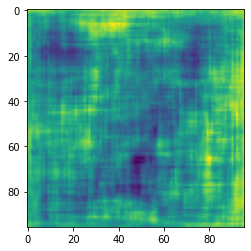

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49987963]], shape=(1, 1), dtype=float32)


Loss functions must be developed that allow the generator and discriminator to be trained in an adversarial way.  Because these two neural networks are being trained independently they must be trained in two separate passes.  This requires two separate loss functions and also two separate updates to the gradients.  When the discriminator's gradients are applied to decrease the discriminator's loss it is important that only the discriminator's weights are update.  It is not fair, nor will it produce good results, to adversarially damage the weights of the generator to help the discriminator.  A simple backpropagation would do this.  It would simultaneously affect the weights of both generator and discriminator to lower whatever loss it was assigned to lower.

Figure 7.TDIS shows how the discriminator is trained.

**Figure 7.TDIS: Training the Discriminator**
![Training the Discriminator](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_fig_2.png "Training the Discriminator")

Here a training set is generated with an equal number of real and fake images.  The real images are randomly sampled (chosen) from the training data.  An equal number of random images are generated from random seeds.  For the discriminator training set, the $x$ contains the input images and the $y$ contains a value of 1 for real images and 0 for generated ones.

Likewise, the Figure 7.TGEN shows how the generator is trained.

**Figure 7.TGEN: Training the Generator**
![Training the Generator](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_fig_3.png "Training the Generator")

For the generator training set, the $x$ contains the random seeds to generate images and the $y$ always contains the value of 1, because the optimal is for the generator to have generated such good images that the discriminiator was fooled into assigning them a probability near 1.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum.  This does not need to be the case.  If you use a **GENERATE_RES** greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.  

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

The following function is where most of the training takes place for both the discriminator and the generator.  This function was based on the GAN provided by the [TensorFlow Keras exmples](https://www.tensorflow.org/tutorials/generative/dcgan) documentation.  The first thing you should notice about this function is that it is annotated with the **tf.function** annotation.  This causes the function to be precompiled and improves performance.

This function trans differently than the code we previously saw for training.  This code makes use of **GradientTape** to allow the discriminator and generator to be trained together, yet separately.  



In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')


In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=11.820141792297363,disc loss=0.03583551570773125, 0:00:12.62
Epoch 2, gen loss=12.064591407775879,disc loss=0.05571359023451805, 0:00:12.75
Epoch 3, gen loss=12.587247848510742,disc loss=0.058134596794843674, 0:00:12.92
Epoch 4, gen loss=12.870683670043945,disc loss=0.421866774559021, 0:00:12.91
Epoch 5, gen loss=11.874146461486816,disc loss=0.08274255692958832, 0:00:12.76
Epoch 6, gen loss=11.285865783691406,disc loss=0.07345473021268845, 0:00:12.74
Epoch 7, gen loss=11.877720832824707,disc loss=0.08619515597820282, 0:00:12.73
Epoch 8, gen loss=12.648554801940918,disc loss=0.04077291861176491, 0:00:12.77
Epoch 9, gen loss=12.141498565673828,disc loss=0.04438399896025658, 0:00:12.76
Epoch 10, gen loss=12.574902534484863,disc loss=0.0632077008485794, 0:00:12.76
Epoch 11, gen loss=12.238516807556152,disc loss=0.04817839339375496, 0:00:12.76
Epoch 12, gen loss=11.654404640197754,disc loss=0.0505911260843277, 0:00:12.75
Epoch 13, gen loss=12.839620590209961,disc loss=0.06

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))